In [1]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import albumentations as A
!pip install keras-tuner
import keras_tuner as kt
!pip install fpdf
from tqdm import tqdm
from collections import Counter
from fpdf import FPDF
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=b03987b8e7c9e6125cf4001562b29ebda4ff6757471adc32b4ef9f3d1df0914b
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [5]:
data_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT'
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset path {data_path} does not exist!")

data_summary = []
total_images, total_masks = 0, 0
for folder_name in tqdm(os.listdir(data_path), desc="Processing Folders"):
    folder_path = os.path.join(data_path, folder_name)
    if not os.path.isdir(folder_path):
        continue
    count = Counter("_mask" in file for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg')))
    image_count, mask_count = count[False], count[True]
    total_images += image_count
    total_masks += mask_count
    data_summary.append({"Category": folder_name, "Images": image_count, "Masks": mask_count})

df = pd.DataFrame(data_summary)
df.to_csv("dataset_summary.csv", index=False)
print("\n✅ Summary saved to dataset_summary.csv")


Processing Folders: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


✅ Summary saved to dataset_summary.csv


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-6-20c871e12fa7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['Category'], y=df['Images'], palette='viridis')


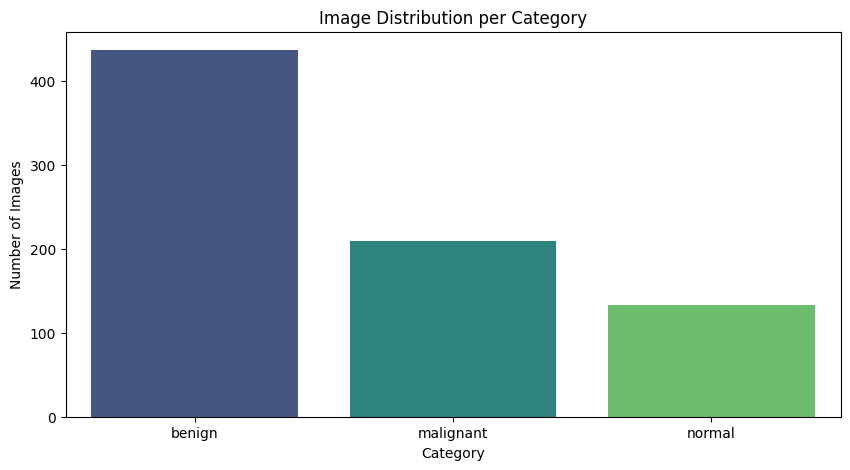

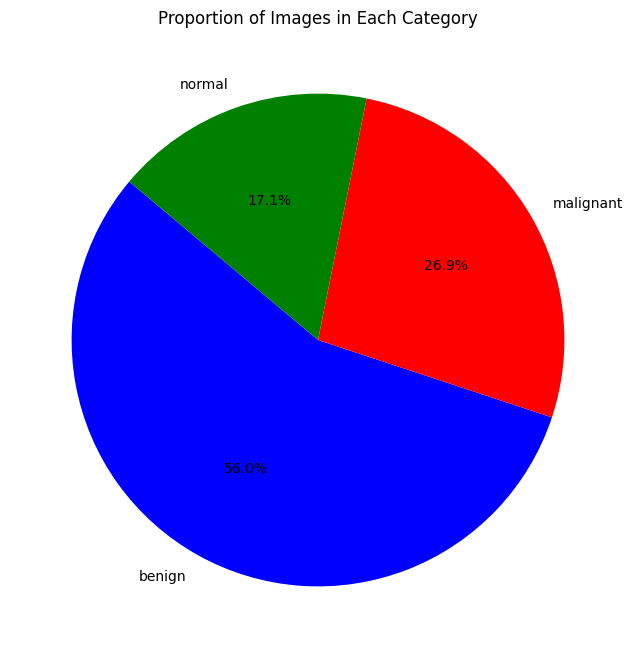

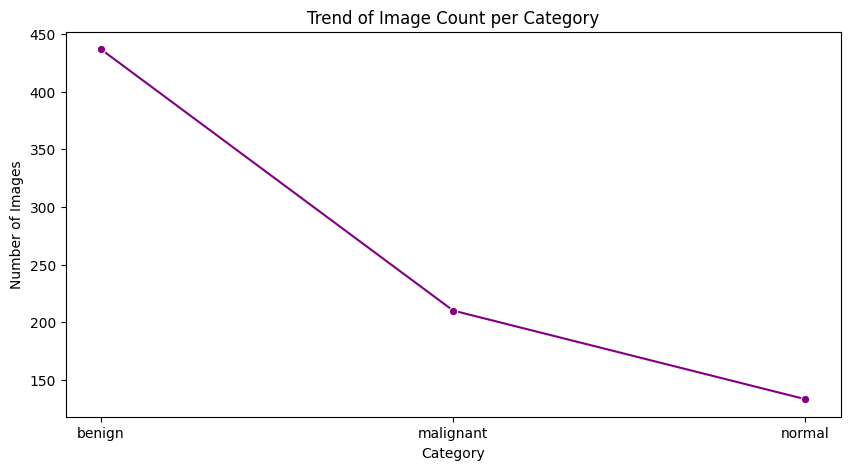

In [6]:
plt.figure(figsize=(10, 5))
sns.barplot(x=df['Category'], y=df['Images'], palette='viridis')
plt.title('Image Distribution per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(df['Images'], labels=df['Category'], autopct='%1.1f%%', colors=['blue', 'red', 'green'], startangle=140)
plt.title('Proportion of Images in Each Category')
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(x=df['Category'], y=df['Images'], marker='o', color='purple')
plt.title('Trend of Image Count per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

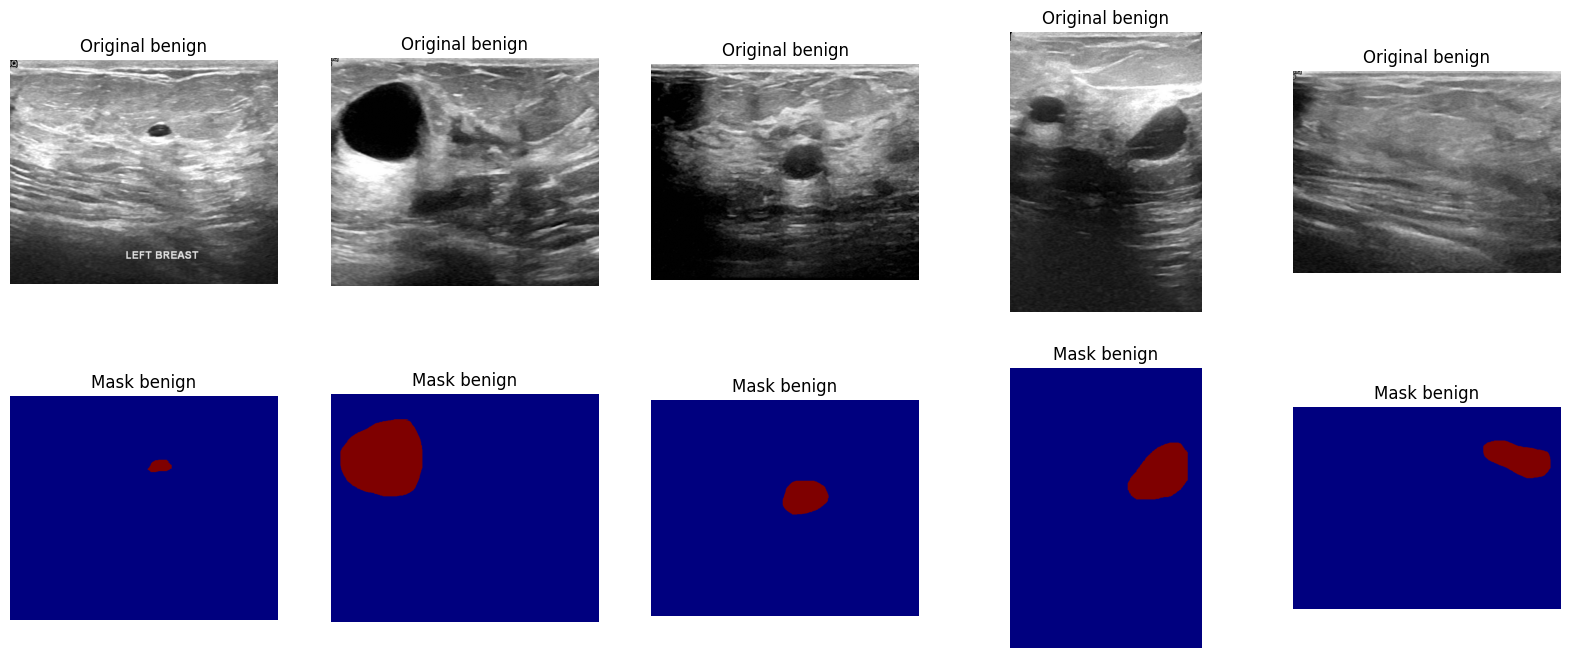

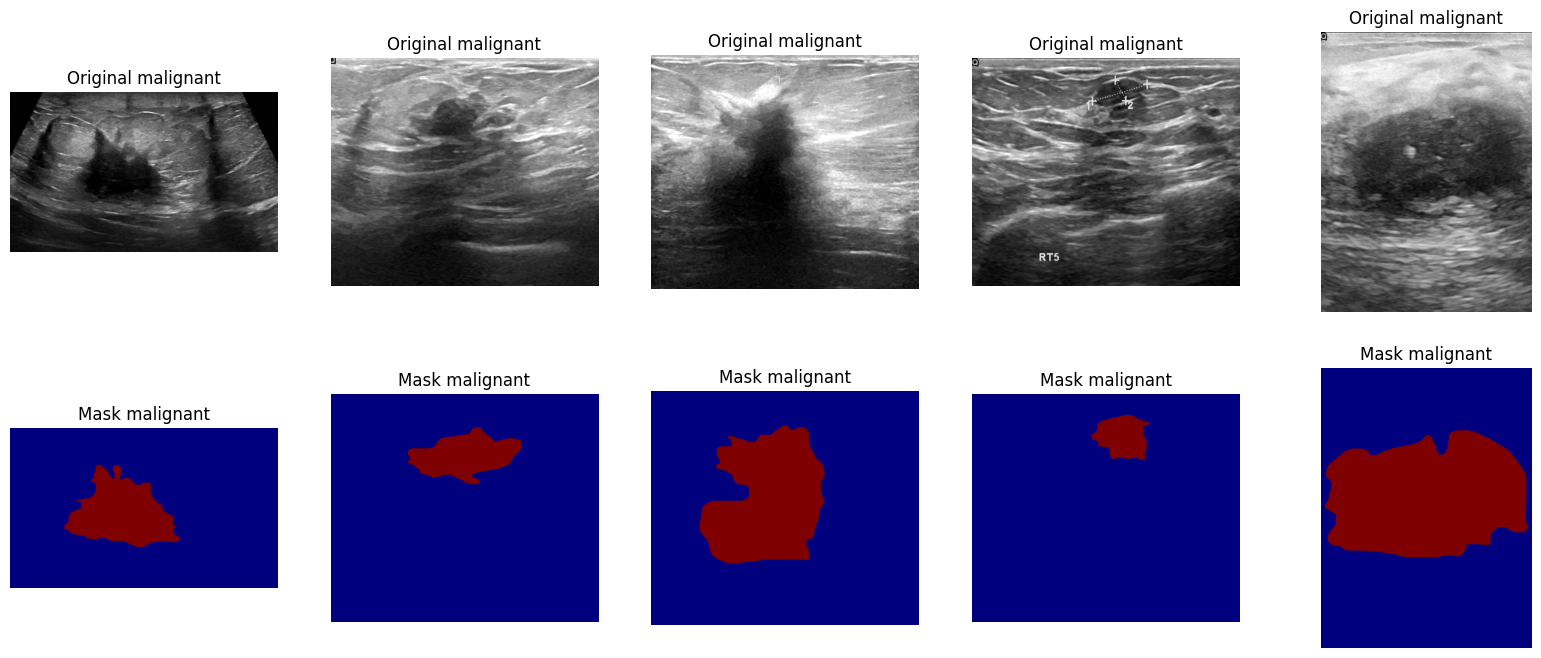

In [7]:
def show_images(category, num_images=10):
    category_path = os.path.join(data_path, category)
    images = [f for f in os.listdir(category_path) if "_mask" not in f][:num_images]
    masks = [f.replace('.png', '_mask.png').replace('.jpg', '_mask.jpg') for f in images]

    fig, axes = plt.subplots(2, num_images//2, figsize=(20, 8))
    for i in range(num_images//2):
        img = cv2.imread(os.path.join(category_path, images[i]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(category_path, masks[i]), cv2.IMREAD_GRAYSCALE)

        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"Original {category}")
        axes[0, i].axis("off")

        axes[1, i].imshow(mask, cmap='jet')
        axes[1, i].set_title(f"Mask {category}")
        axes[1, i].axis("off")
    plt.show()

show_images("benign")
show_images("malignant")

In [8]:
def load_data(data_dir, img_size=(224, 224)):
    images, labels = [], []
    categories = {"benign": 0, "malignant": 1}

    for category, label in categories.items():
        path = os.path.join(data_dir, category)
        if not os.path.exists(path): continue

        for img_name in os.listdir(path):
            if "_mask" in img_name: continue  # Ignore masks

            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size) / 255.0  # Normalize

            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

X, y = load_data(data_path)
y = tf.keras.utils.to_categorical(y, num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2]
)

In [10]:
import keras_tuner as kt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg16_base.trainable = False

    x = GlobalAveragePooling2D()(vgg16_base.output)
    x = Dense(hp.Int('units', 128, 256, step=128), activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inputs=vgg16_base.input, outputs=out)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='vgg16_tuning'
)

tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
)


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)


Trial 2 Complete [00h 23m 46s]
val_accuracy: 0.6769230961799622

Best val_accuracy So Far: 0.7923076748847961
Total elapsed time: 00h 49m 00s


In [11]:
# Training the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5  # Keeping it minimal for speed
)

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 291s 17s/step - accuracy: 0.5520 - loss: 0.8189 - val_accuracy: 0.6769 - val_loss: 0.6009
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 316s 17s/step - accuracy: 0.6575 - loss: 0.6512 - val_accuracy: 0.6769 - val_loss: 0.5976
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 290s 15s/step - accuracy: 0.6662 - loss: 0.6210 - val_accuracy: 0.6923 - val_loss: 0.5535
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 284s 17s/step - accuracy: 0.6995 - loss: 0.5700 - val_accuracy: 0.8000 - val_loss: 0.5522
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 320s 17s/step - accuracy: 0.7500 - loss: 0.5312 - val_accuracy: 0.8077 - val_loss: 0.5317


✅ Test Accuracy: 80.77%
🔍 Test Loss: 0.5317

📊 Classification Report:
               precision    recall  f1-score   support

      Benign       0.81      0.93      0.87        88
   Malignant       0.79      0.55      0.65        42

    accuracy                           0.81       130
   macro avg       0.80      0.74      0.76       130
weighted avg       0.81      0.81      0.80       130



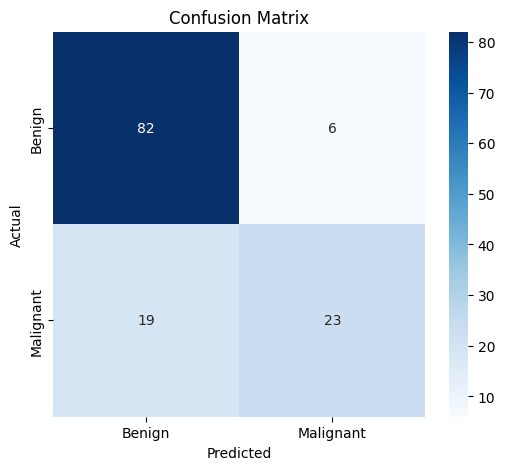

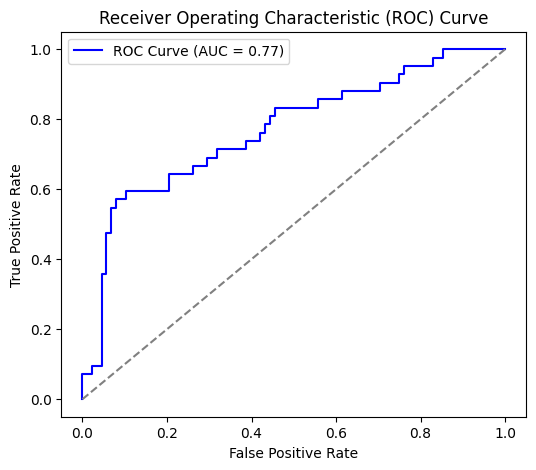

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"🔍 Test Loss: {loss:.4f}\n")

# Predict probabilities and classes
y_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("📊 Classification Report:\n", classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve (for binary classification)
fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])  # Assuming class 1 (Malignant) is the positive class
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
⚠️ You have breast cancer with 64.48% confidence. Visit the doctor.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


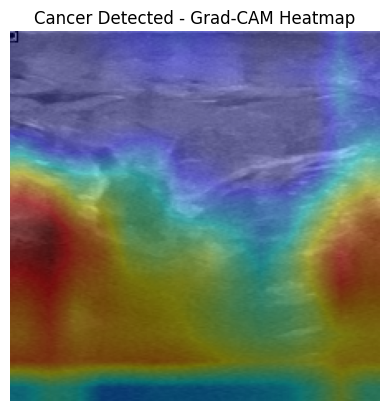

✅ Report saved as breast_cancer_report.pdf


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF
import tensorflow as tf
import os

def generate_report(img_path, prediction, confidence, heatmap_path=None):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", style='', size=12)
    pdf.cell(200, 10, "Breast Cancer Detection Report", ln=True, align='C')
    pdf.ln(10)
    pdf.cell(200, 10, f"Prediction: {'Malignant' if prediction == 1 else 'Benign'}", ln=True)
    pdf.cell(200, 10, f"Confidence: {confidence:.2f}%", ln=True)
    pdf.ln(10)

    if prediction == 1:
        pdf.cell(200, 10, "Recommendation: Visit the doctor immediately.", ln=True)
    else:
        pdf.cell(200, 10, "Recommendation: No cancer detected. You are healthy.", ln=True)

    pdf.ln(10)

    pdf.output("breast_cancer_report.pdf")
    print("✅ Report saved as breast_cancer_report.pdf")
    os.system("open breast_cancer_report.pdf" if os.name == "posix" else "start breast_cancer_report.pdf")

def compute_gradcam(model, img_array, layer_name='block5_conv3'):
    grad_model = tf.keras.models.Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 1]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = np.mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap

def overlay_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    overlay_path = "cancer_detected.png"
    cv2.imwrite(overlay_path, overlay)
    return overlay_path

def predict_uploaded_image(img_path, model):
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224)) / 255.0  # Normalize
        img_array = np.expand_dims(img, axis=0)
        prediction = model.predict(img_array)
        class_idx = np.argmax(prediction)
        confidence = prediction[0][class_idx] * 100

        if class_idx == 1:  # Malignant (Cancer detected)
            print(f"⚠️ You have breast cancer with {confidence:.2f}% confidence. Visit the doctor.")
            heatmap = compute_gradcam(model, img_array)
            heatmap_path = overlay_gradcam(img_path, heatmap)
            plt.imshow(cv2.cvtColor(cv2.imread(heatmap_path), cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title("Cancer Detected - Grad-CAM Heatmap")
            plt.show()
            generate_report(img_path, class_idx, confidence, heatmap_path)
        else:
            print("✅ No cancer detected. You are healthy.")
            plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title("No Cancer Detected")
            plt.show()
            generate_report(img_path, class_idx, confidence)
    except Exception as e:
        print(f"❌ Error processing image: {e}")

# Example Usage
predict_uploaded_image('/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (3).png', model)
